In [1]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy import stats
from Bio.Blast import NCBIXML
from Bio.Blast import NCBIWWW
from Bio import SeqIO
import numpy as np

## Enrichment analysis

In [2]:
def locations_import(file):
    """
    Function for importing locations to which reads aligned. 
    Returns a nested list. first item contains the names that correspond to the second list. 
    The second item has a list for each each name listed in the first. Each number within each 
    list corresponds to a location on the pB10 or chromosomal genome that each read aligned.
    """
    final_locations = []
    data = open(file, 'r').read()
    data_list = data.split('\n') 
    
    contents = data_list[0]
    locations = data_list[1:-1]
    
    for item in locations:       
        coords = item[1:-1].split(',')
        coords_list = list(map(int, coords))
        final_locations.append(coords_list)
    return([contents, final_locations])

def normalize(df):
    """
    Function for normalizing data to the lowest number of reads
    """
    lowest_seq = df['num_reads'].min()
    df['standard'] = lowest_seq/df['num_reads']
    df['pb10_pb10'] = df['pb10_pb10'] * df['standard']
    df['pb10_ecoli'] = df['pb10_ecoli'] * df['standard']
    df['pb10_pputida'] = df['pb10_pputida'] * df['standard']
    df.drop(columns='standard', inplace=True)
    df.drop(columns='num_reads', inplace=True)
    return(df)

def plot_coverage(file, ax1, ax2, ax3, xlabels='off'):
    """
    Function for making coverage plots
    """
    df = pd.read_csv(file)
    pb10_pb10 = df['pb10_pb10'].to_list()
    ecoli_pb10 = df['pb10_ecoli'].to_list()
    pputida_pb10 = df['pb10_pputida'].to_list()
    
    x = list(range(len(pputida_pb10)))
    
    ax1.plot(x, pb10_pb10,
        color='black',
        linewidth=.05)
    ax1.fill_between(x, pb10_pb10, 0, color='black', alpha=.5)
    
    ax2.plot(x, ecoli_pb10,
            color='black',
            linewidth=.1)    
    ax2.fill_between(x, ecoli_pb10, 0, color='black', alpha=.5)
    
    ax3.plot(x, pputida_pb10,
            color='black',
            linewidth=.1)    
    ax3.fill_between(x, pputida_pb10, 0, color='black', alpha=.5)
    
    for ax in [ax1, ax2, ax3]:
        ax.set(yscale='log')
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.autoscale(enable=True, axis='x', tight=True)
        ax.margins(y=0)
        plt.setp(ax1.spines.values(), linewidth=.75)
        ax.xaxis.set_tick_params(width=.75)
        ax.yaxis.set_tick_params(width=.75)
        ax.set_ylim(1, 1000000)
        ax.minorticks_off()
        if xlabels == 'off':
            ax.xaxis.set_ticklabels([])

    ax2.yaxis.set_ticklabels([])
    ax3.yaxis.set_ticklabels([])
    
def import_fasta(fname):
    contents=[]
    with open(fname, 'r') as file:
        for line in file:
            contents.append(line.strip())          
    return(contents)

In [ ]:
os.chdir('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/enrichment_comparison/')

#import count data from each Hi-C and Hi-C+ library
count_data = pd.DataFrame(columns=['pb10_pb10', 'pb10_ecoli', 'pb10_pputida', 'library'])
for file in ['A_read_count.csv', 'B_read_count.csv', 'C_read_count.csv', 'D_read_count.csv', 'E_read_count.csv', 'Ctrl_read_count.csv', 
             'B+_read_count.csv', 'C+_read_count.csv', 'D+_read_count.csv', 'E+_read_count.csv', 'F+_read_count.csv', 'Ctrl+_read_count.csv']:
    data = pd.read_csv(file)
    data['library'] = file.split('_')[0]
    count_data = count_data.append(data)
count_data['type'] = ['hic', 'hic', 'hic', 'hic', 'hic', 'hic', 'hic+', 'hic+', 'hic+', 'hic+', 'hic+', 'hic+']

#get sequencing depth from multiqc report
seq_depth = pd.read_csv('../../04_fastqc/trimmed/trimmed_data/multiqc_general_stats.txt', sep='\t')[['Sample', 'FastQC_mqc-generalstats-fastqc-total_sequences']].rename(columns={'FastQC_mqc-generalstats-fastqc-total_sequences':'num_reads'}).iloc[::2]
seq_depth['library'] = seq_depth.Sample.str[:-2]
seq_depth.drop(columns=['Sample'], inplace=True)

#merge sequencing depth with count data 
count_data = pd.merge(seq_depth, count_data, on='library')

#separate hic and hic+ and normalize to lowest sequencing depth
hicplus = normalize(count_data.loc[count_data['type']=='hic+'])
hicplus['library'] = hicplus.library.str[:-1]
hic = normalize(count_data.loc[count_data['type']=='hic'])

#convert dataframes to long format for plotting
hicplus = hicplus.melt(id_vars=['library'], value_vars=['pb10_pb10', 'pb10_ecoli', 'pb10_pputida'], 
                       var_name = 'read', value_name='count')
hic = hic.melt(id_vars=['library'], value_vars=['pb10_pb10', 'pb10_ecoli', 'pb10_pputida'],
               value_name='count', var_name='read')

#add type columns and plate count data
hic['type'] = 'Hi-C'
hicplus['type'] = 'Hi-C+'

#### Figure 2

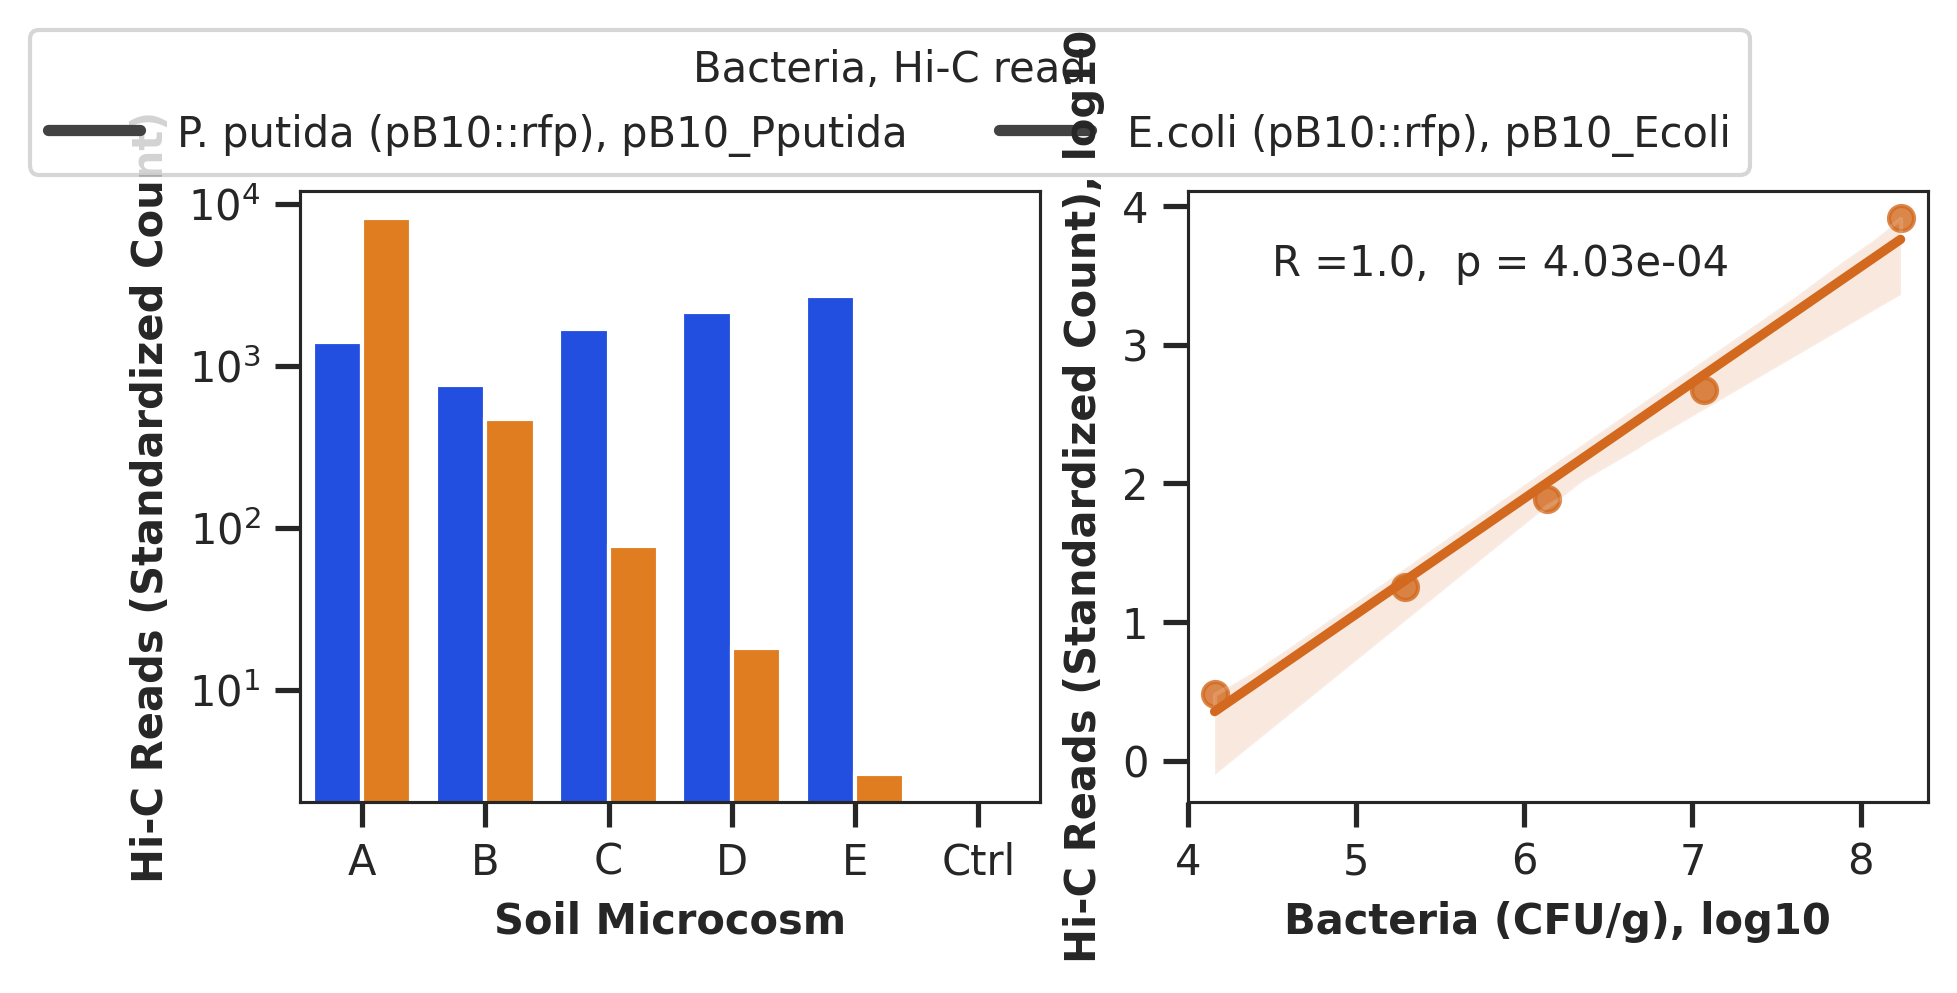

In [10]:
######Figure 2
os.chdir('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/enrichment_comparison/')
#make dataframe with data for figure 1A, add plate count and bacteria columns 
fig2_data = hic.loc[hic['read']!='pb10_pb10'].copy()
fig2_data.loc[:,'plate_counts'] = [1.54e6, 9.51e5,1.52e6, 0, 1.87e6,1.24e6,
                                    1.73e8,1.18e7,1.37e6, 0, 1.94e5,1.44e4]
fig2_data.loc[:,'bacteria'] = ['Donor']*6 + ['Transconjugant']*6
fig2_data.loc[:,'count'] = fig2_data['count'].astype(int)
fig2_data.loc[:,'plate_counts'] = fig2_data['plate_counts'].astype(int)

#make dataframes with data for figure 2B, log10 transform values
reg1 = fig2_data.loc[(fig2_data['library']!='Ctrl')&(fig2_data['bacteria']=='Transconjugant')].copy()
reg1.loc[:,'log_count'] = np.log10(reg1['count'])
reg1.loc[:,'log_plate_counts'] = np.log10(reg1['plate_counts'])
reg2 = fig2_data.loc[(fig2_data['library']!='Ctrl')&(fig2_data['bacteria']=='Donor')].copy()
reg2.loc[:,'log_count'] = np.log10(reg2['count'])
reg2.loc[:,'log_plate_counts'] = np.log10(reg2['plate_counts'])

#make plot for figure 2
fig2, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(7,2.7), dpi=300)
sns.set(style='ticks')
sns.barplot(data = fig2_data, x='library', y='count', 
            order=['A', 'B', 'C', 'D', 'E',  'Ctrl'],
            hue='read', palette = 'bright', ax=ax1).set_yscale('log')
ax1.legend(labels=['P. putida (pB10::rfp), pB10_Pputida', 'E.coli (pB10::rfp), pB10_Ecoli'], loc='upper right', 
           bbox_to_anchor=(1.99,1.3), ncol=2, title='Bacteria, Hi-C read')
sns.regplot(x='log_plate_counts', y='log_count', data=reg1, ax=ax2, label='Transconjugant', color='chocolate')

ax1.minorticks_off()
ax1.set_ylabel('Hi-C Reads (Standardized Count)', fontsize=10, fontweight='bold')
ax1.set_xlabel('Soil Microcosm', fontsize=10, fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=10)

ax2.set_ylabel('Hi-C Reads (Standardized Count), log10', fontsize=10, fontweight='bold')
ax2.set_xlabel('Bacteria (CFU/g), log10', fontsize=10, fontweight='bold')
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.yaxis.set_major_locator(mticker.MultipleLocator(1))
ax2.set_xlim(4,8.4)

plt.setp(ax1.get_legend().get_texts(), fontsize='10') 
plt.setp(ax1.get_legend().get_title(), fontsize='10') 
plt.setp(ax1.spines.values(), linewidth=.75)
plt.setp(ax2.spines.values(), linewidth=.75)

r,p = stats.pearsonr(reg1['log_plate_counts'], reg1['log_count'])
ax2.text(4.5, 3.5, 'R =' + str(round(r)) + ',  p = ' + str("{:.2e}".format(p)), fontsize=10)

plt.savefig('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/figures/Fig2.pdf', bbox_inches='tight', dpi=300)

#### Figure 4

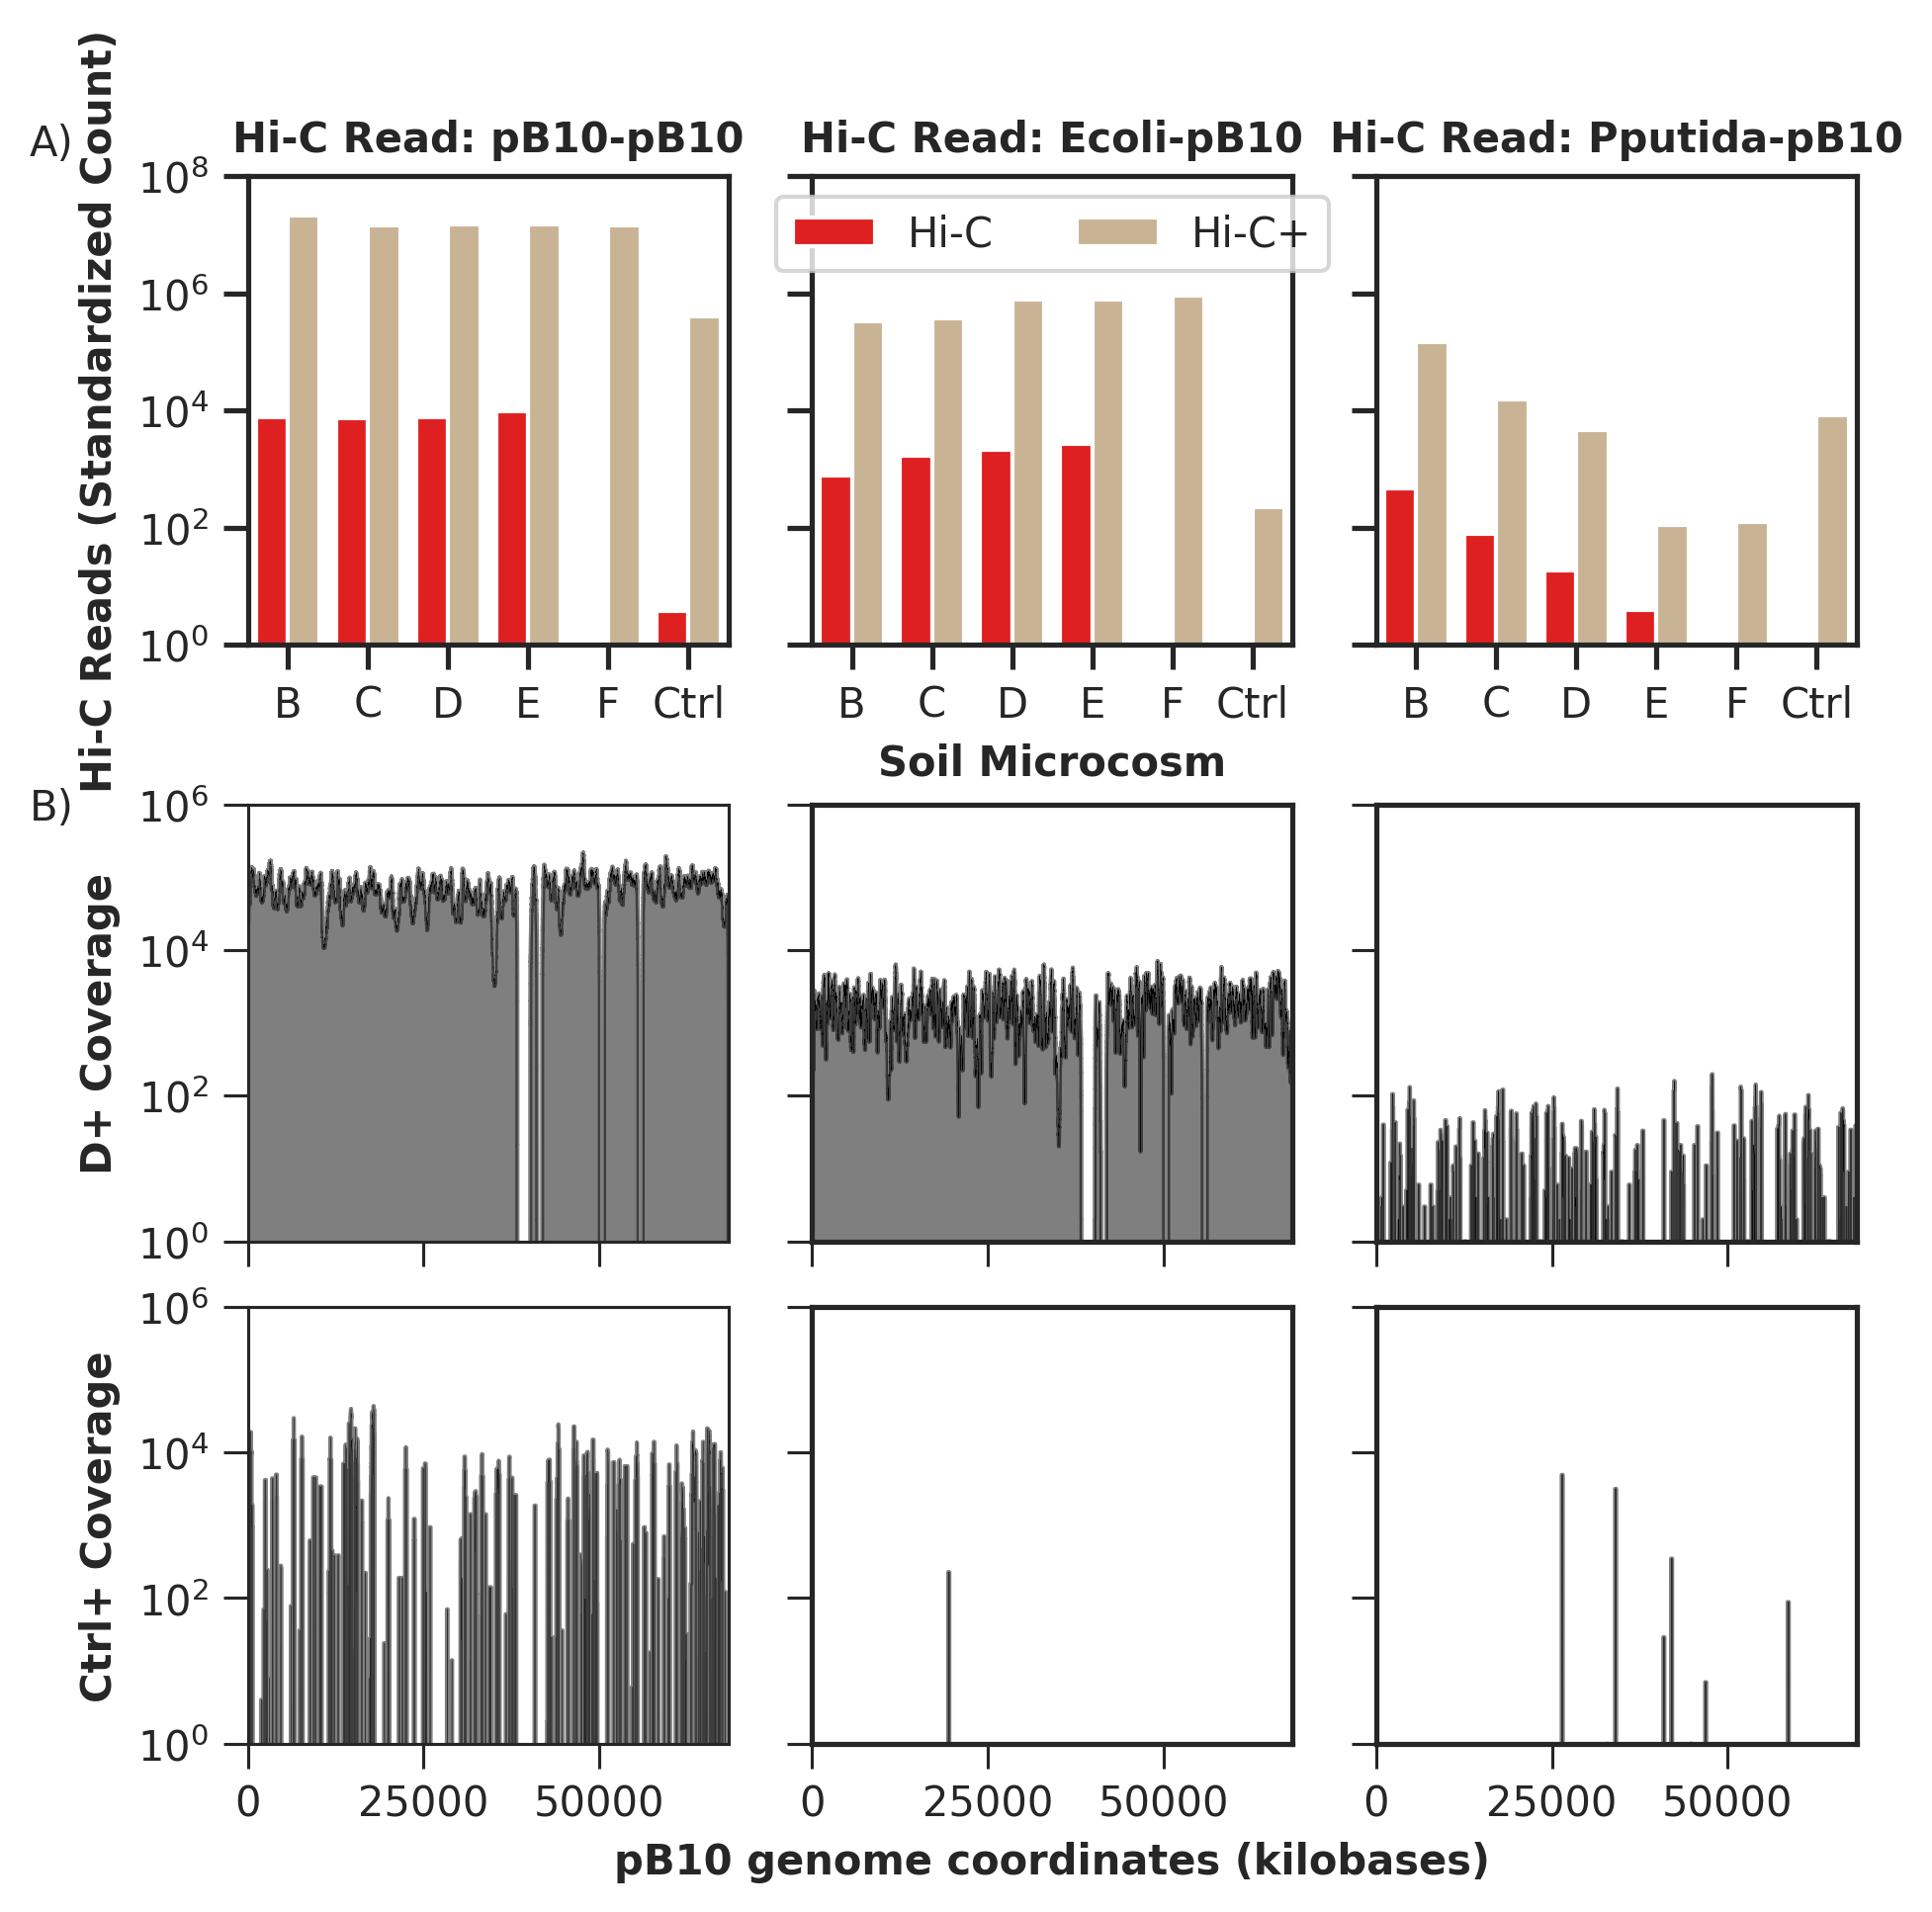

In [15]:
os.chdir('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/enrichment_comparison/')
#make dataframe with data for figure 3A. hic and hic+ counts are combined
fig4A_data = pd.concat([hic, hicplus], ignore_index=True, axis=0)

fig4A_data.rename(columns={'library':'Index', 'read':'Hi-C link'}, inplace=True)
fig4A_data.replace({'pb10_pb10':'pB10-pB10', 'pb10_ecoli':'Ecoli-pB10', 'pb10_pputida':'Pputida-pB10'}, inplace=True)

####Figure3
fig4 = plt.figure(figsize=(7, 7), dpi=300)
gs = fig4.add_gridspec(100, 100)

rc = {'font.size': 10.0, 'axes.labelsize': 10.0, 'axes.titlesize': 10.0, 'xtick.labelsize': 10.0,
      'ytick.labelsize': 10.0, 'legend.fontsize': 10.0, 'legend.title_fontsize': 10.0, "font.family": "Helvetica"}
sns.set(style='ticks', rc=rc)


ax1 = fig4.add_subplot(gs[:30,0:30])
ax2 = fig4.add_subplot(gs[:30,35:65])
ax3 = fig4.add_subplot(gs[:30,70:])
ax4 = fig4.add_subplot(gs[40:68,0:30])
ax5 = fig4.add_subplot(gs[40:68,35:65])
ax6 = fig4.add_subplot(gs[40:68,70:])
ax7 = fig4.add_subplot(gs[72:,0:30])
ax8 = fig4.add_subplot(gs[72:,35:65])
ax9 = fig4.add_subplot(gs[72:,70:])

plt.figtext(0.02, 0.89, 'A)', fontsize=10)
plt.figtext(0.02, 0.57, 'B)', fontsize=10)

#----------------------------------- panel A -----------------------------------------------
sns.barplot(data = fig4A_data[fig4A_data['Hi-C link']=='pB10-pB10'], x='Index', y='count', 
            hue='type', palette={'Hi-C':'red', 'Hi-C+':'tan'}, ax=ax1, 
            order=['B', 'C', 'D', 'E', 'F', 'Ctrl']).set(yscale='log')
ax1.set_ylim(1, 100000000)
ax1.set_ylabel('Hi-C Reads (Standardized Count)', fontsize=10, fontweight='bold')
ax1.set(xlabel=None)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.set_title('Hi-C Read: pB10-pB10', fontsize=10, fontweight='bold')
ax1.legend('',frameon=False)

sns.barplot(data = fig4A_data[fig4A_data['Hi-C link']=='Ecoli-pB10'], x='Index', y='count', 
            hue='type', palette={'Hi-C':'red', 'Hi-C+':'tan'}, ax=ax2, 
            order=['B', 'C', 'D', 'E', 'F', 'Ctrl']).set(yscale='log')
ax2.set_xlabel('Soil Microcosm', fontsize=10, fontweight='bold')
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.legend(loc='upper center', ncol=2)
ax2.set(ylabel=None)
ax2.set_title('Hi-C Read: Ecoli-pB10', fontsize=10, fontweight='bold')
ax2.set_ylim(1, 100000000)
ax2.tick_params(axis='y', label1On=False)
ax2.yaxis.set_ticklabels([])

sns.barplot(data = fig4A_data[fig4A_data['Hi-C link']=='Pputida-pB10'], x='Index', y='count', 
            hue='type', palette={'Hi-C':'red', 'Hi-C+':'tan'}, ax=ax3, 
            order=['B', 'C', 'D', 'E', 'F', 'Ctrl']).set(yscale='log')
ax3.tick_params(axis='both', which='major', labelsize=10)
ax3.set(ylabel=None)
ax3.set(xlabel=None)
ax3.set_title('Hi-C Read: Pputida-pB10', fontsize=10, fontweight='bold')
ax3.set_ylim(1, 100000000)
ax3.tick_params(axis='y', label1On=False)
ax3.yaxis.set_ticklabels([])
ax3.legend('',frameon=False)

#make coverage plots
plot_coverage('D+_plasmid_coverage.csv', ax4, ax5, ax6)
plot_coverage('Ctrl+_plasmid_coverage.csv', ax7, ax8, ax9, 'on')
ax4.set_ylabel('D+ Coverage', fontsize=10, fontweight='bold')
ax7.set_ylabel('Ctrl+ Coverage', fontsize=10, fontweight='bold')
ax8.set_xlabel('pB10 genome coordinates (kilobases)', fontsize=10, fontweight='bold')

plt.savefig('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/figures/fig4.pdf', bbox_inches='tight', dpi=300)

#### Figure 6

In [12]:
os.chdir('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/enrichment_comparison/')

#import control first and create column with combined coverage from all read types
ctrl = pd.read_csv('Ctrl+_plasmid_coverage.csv')
ctrl['sum'] = ctrl[['pb10_pb10', 'pb10_ecoli', 'pb10_pputida']].sum(axis=1)
ctrl_detected = ctrl['sum'].to_list()

#add normalization factor to sequencing depth dataframe
count_data.loc[:,'all_norm'] = count_data['num_reads'].min()/count_data['num_reads']

def unique_positions(ctrl, pb10):
    unique = []
    for i, j in zip(ctrl, pb10):
        if i == 0 and j > 0:
            unique.append(1)
        else:
            unique.append(0)
    return(unique)

files = glob.glob('*plasmid_coverage.csv')
files = sorted(files)[1:]

plot_cov = pd.DataFrame()

for file in files:
    name = file.split('_')[0]
    data = pd.read_csv(file)
    
    covered_bases = [np.count_nonzero(data['pb10_pb10']), 
                     np.count_nonzero(data['pb10_ecoli']), 
                     np.count_nonzero(data['pb10_pputida'])]
    
    percent_covered = [(covered_bases[0]/len(ctrl))*100, 
                       (covered_bases[1]/len(ctrl))*100, 
                       (covered_bases[2]/len(ctrl))*100]
    
    unique_bases = [np.count_nonzero(unique_positions(ctrl_detected, data['pb10_pb10'])), 
                    np.count_nonzero(unique_positions(ctrl_detected, data['pb10_ecoli'])), 
                    np.count_nonzero(unique_positions(ctrl_detected, data['pb10_pputida']))]
    
    ctrl_zeros = ctrl['sum'].to_list().count(0)
    percent_unique = [(unique_bases[0]/ctrl_zeros)*100, 
                      (unique_bases[1]/ctrl_zeros)*100, 
                      (unique_bases[2]/ctrl_zeros)*100]    
    

    df = pd.DataFrame.from_dict({'covered_bases':covered_bases,
                                 'percent_covered':percent_covered,
                                 'unique_bases':unique_bases,
                                 'percent_unique':percent_unique,
                                 'read':['pB10-pB10', 'Ecoli-pB10', 'Pputida-pB10']})
    if name[-1] == '+':
        df['type'] = 'Hi-C+'
        df['Index'] = name[:-1]
    else:
        df['type'] = 'Hi-C'
        df['Index'] = name
    
    plot_cov = pd.concat([plot_cov, df])

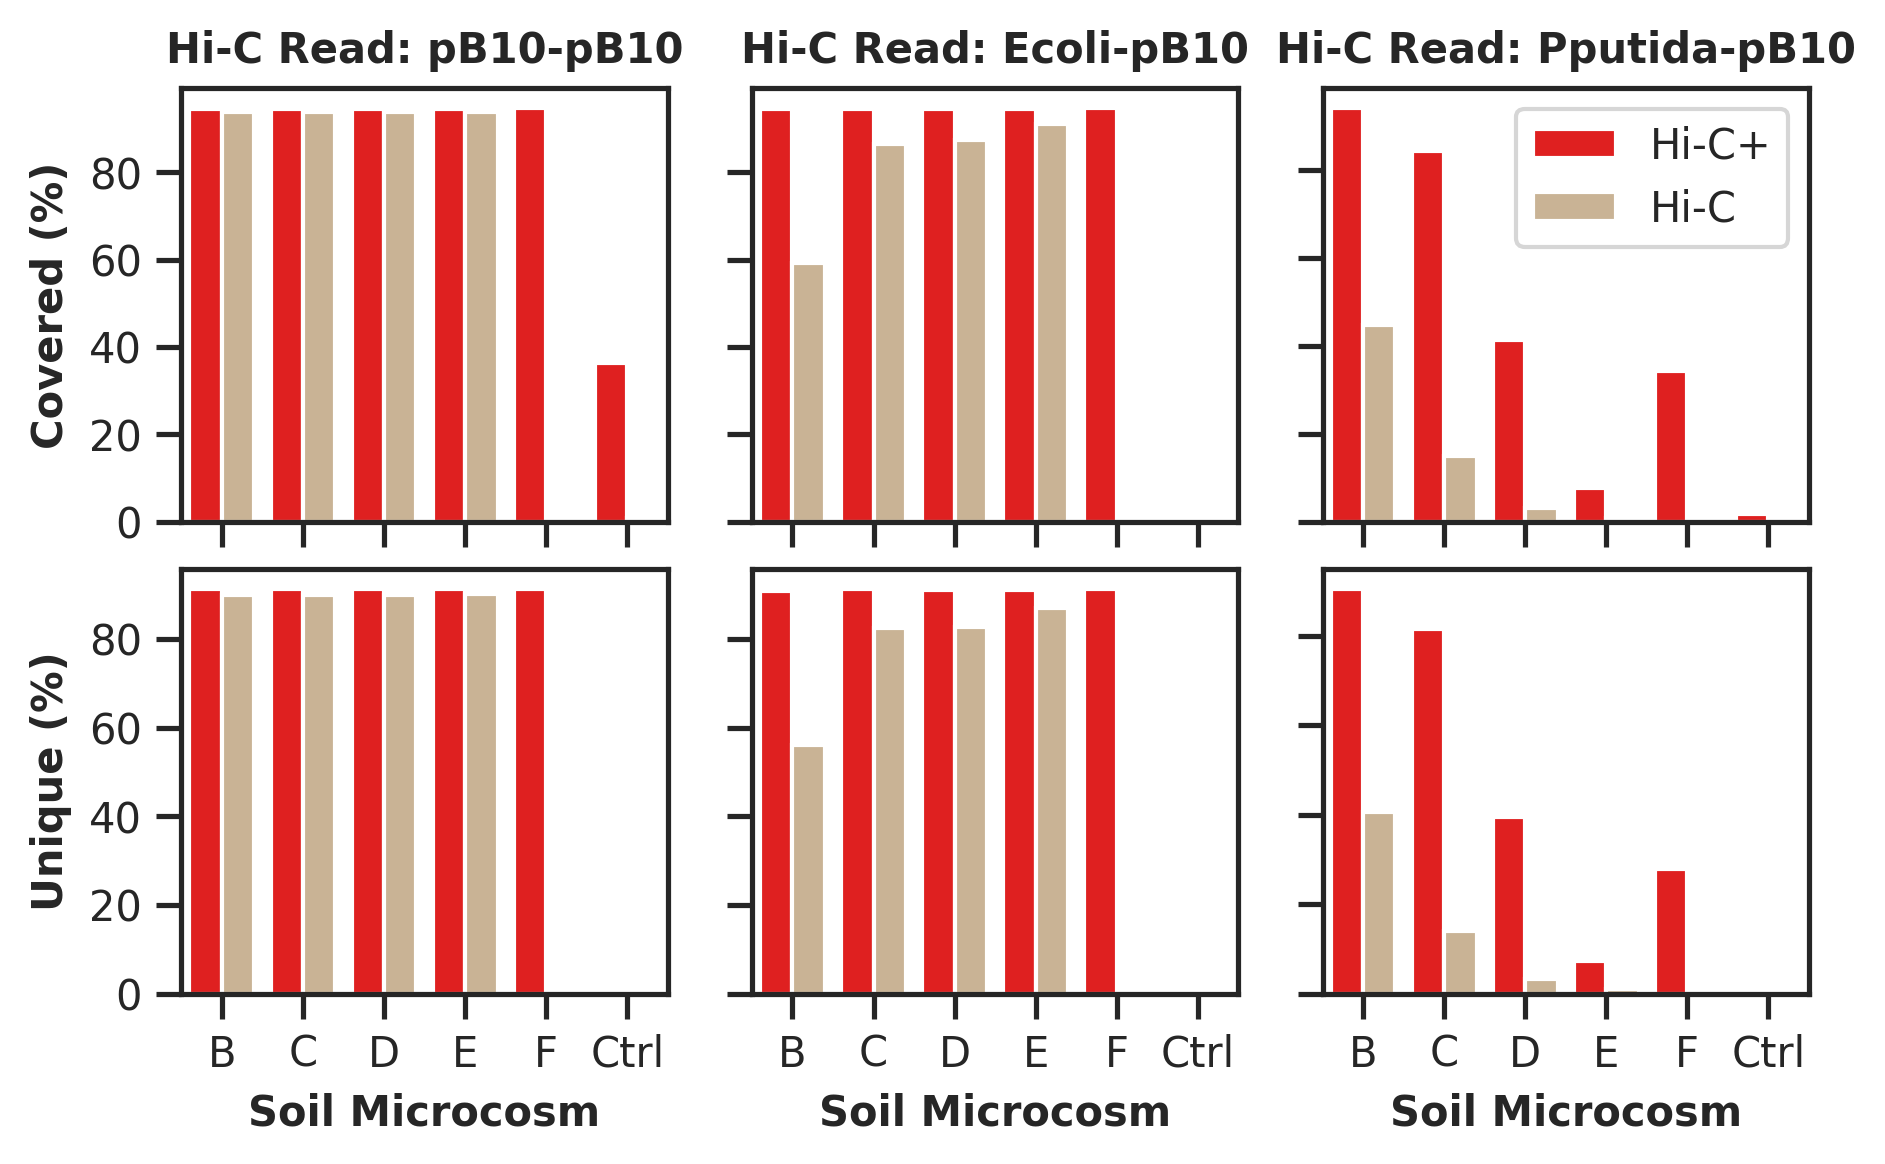

In [13]:
fig6 = plt.figure(figsize=(7, 4), dpi=300)
gs = fig6.add_gridspec(100, 100)

rc = {'font.size': 10.0, 'axes.labelsize': 10.0, 'axes.titlesize': 10.0, 'xtick.labelsize': 10.0,
      'ytick.labelsize': 10.0, 'legend.fontsize': 10.0, 'legend.title_fontsize': 10.0, "font.family": "Helvetica"}
sns.set(style='ticks', rc=rc)

ax1 = fig6.add_subplot(gs[:48,0:30])
ax2 = fig6.add_subplot(gs[:48,35:65])
ax3 = fig6.add_subplot(gs[:48,70:])
ax4 = fig6.add_subplot(gs[53:,0:30])
ax5 = fig6.add_subplot(gs[53:,35:65])
ax6 = fig6.add_subplot(gs[53:,70:])

sns.barplot(data=plot_cov[plot_cov['read']=='pB10-pB10'], x='Index', y='percent_covered', 
            hue='type', order=['B','C','D','E', 'F', 'Ctrl'], palette={'Hi-C+':'red', 'Hi-C':'tan'}, ax=ax1)
ax1.set_ylabel('Covered (%)', fontsize=10, fontweight='bold')
ax1.set(xlabel=None)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.set_title('Hi-C Read: pB10-pB10', fontsize=10, fontweight='bold')
ax1.legend('',frameon=False)
ax1.xaxis.set_ticklabels([])

sns.barplot(data=plot_cov[plot_cov['read']=='Ecoli-pB10'], x='Index', y='percent_covered', 
            hue='type', order=['B','C','D','E', 'F', 'Ctrl'], palette={'Hi-C+':'red', 'Hi-C':'tan'}, ax=ax2)
ax2.set(xlabel=None, ylabel=None)
ax2.set_title('Hi-C Read: Ecoli-pB10', fontsize=10, fontweight='bold')
ax2.tick_params(axis='y', label1On=False)
ax2.yaxis.set_ticklabels([])
ax2.xaxis.set_ticklabels([])
ax2.legend('',frameon=False)

sns.barplot(data=plot_cov[plot_cov['read']=='Pputida-pB10'], x='Index', y='percent_covered', 
            hue='type', order=['B','C','D','E', 'F', 'Ctrl'], palette={'Hi-C+':'red', 'Hi-C':'tan'}, ax=ax3)
ax3.set(xlabel=None, ylabel=None)
ax3.set_title('Hi-C Read: Pputida-pB10', fontsize=10, fontweight='bold')
ax3.tick_params(axis='y', label1On=False)
ax3.yaxis.set_ticklabels([])
ax3.xaxis.set_ticklabels([])
ax3.legend('',frameon=False)
ax3.legend(loc='upper right')

sns.barplot(data=plot_cov[plot_cov['read']=='pB10-pB10'], x='Index', y='percent_unique', 
            hue='type', order=['B','C','D','E', 'F', 'Ctrl'], palette={'Hi-C+':'red', 'Hi-C':'tan'}, ax=ax4)
ax4.set_ylabel('Unique (%)', fontsize=10, fontweight='bold')
ax4.tick_params(axis='both', which='major', labelsize=10)
ax4.legend('',frameon=False)
ax4.set_xlabel('Soil Microcosm', fontsize=10, fontweight='bold')

sns.barplot(data=plot_cov[plot_cov['read']=='Ecoli-pB10'], x='Index', y='percent_unique', 
            hue='type', order=['B','C','D','E', 'F', 'Ctrl'], palette={'Hi-C+':'red', 'Hi-C':'tan'}, ax=ax5)
ax5.set(ylabel=None)
ax5.tick_params(axis='y', label1On=False)
ax5.yaxis.set_ticklabels([])
ax5.legend('',frameon=False)
ax5.set_xlabel('Soil Microcosm', fontsize=10, fontweight='bold')

sns.barplot(data=plot_cov[plot_cov['read']=='Pputida-pB10'], x='Index', y='percent_unique', 
            hue='type', order=['B','C','D','E', 'F', 'Ctrl'], palette={'Hi-C+':'red', 'Hi-C':'tan'}, ax=ax6)
ax6.set(ylabel=None)
ax6.tick_params(axis='y', label1On=False)
ax6.yaxis.set_ticklabels([])
ax6.legend('',frameon=False)
ax6.set_xlabel('Soil Microcosm', fontsize=10, fontweight='bold')

plt.savefig('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/figures/fig6.pdf', bbox_inches='tight', dpi=300)

#### Fig S1

Text(0.5, 0, 'pB10::rfp genome coordinates')

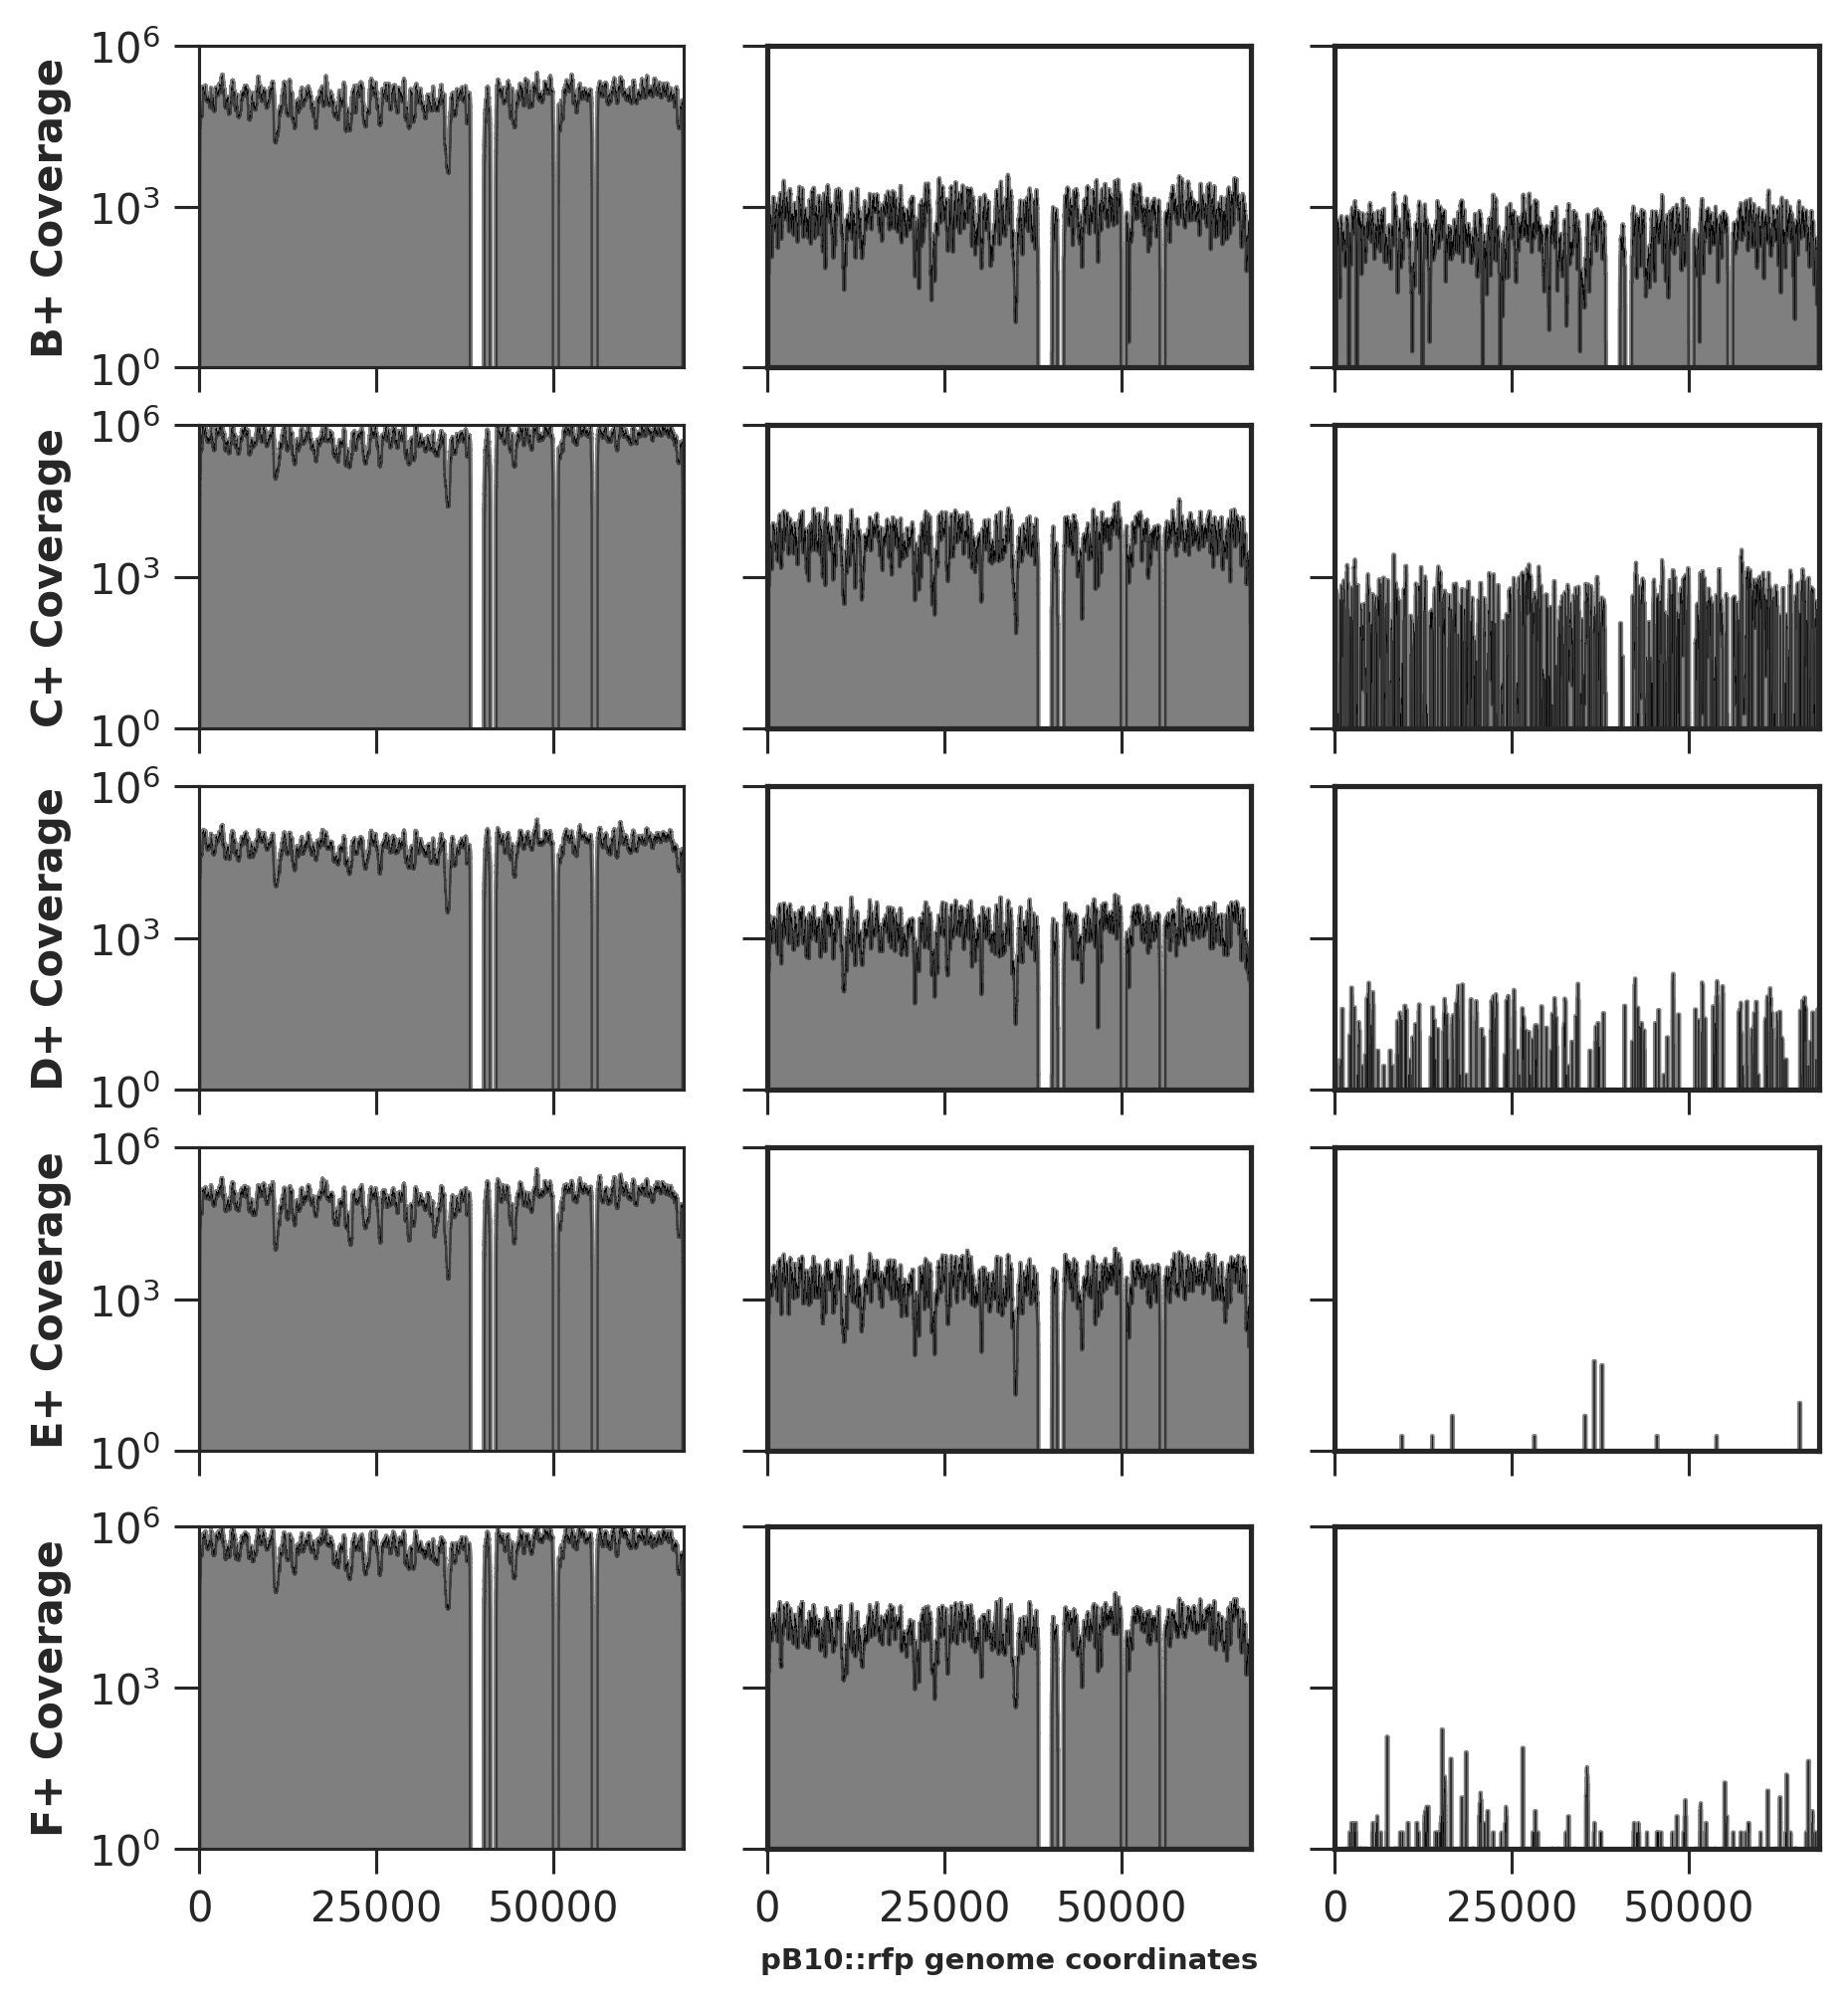

In [15]:
os.chdir('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/enrichment_comparison/')
suppfig2 = plt.figure(figsize=(7, 8), dpi=300)
gs = suppfig2.add_gridspec(100, 100)

rc = {'font.size': 10.0, 'axes.labelsize': 10.0, 'axes.titlesize': 10.0, 'xtick.labelsize': 10.0,
      'ytick.labelsize': 10.0, 'legend.fontsize': 10.0, 'legend.title_fontsize': 10.0, "font.family": "Helvetica"}
sns.set(style='ticks', rc=rc)

ax1 = suppfig2.add_subplot(gs[:18,0:30])
ax2 = suppfig2.add_subplot(gs[:18,35:65])
ax3 = suppfig2.add_subplot(gs[:18,70:])

ax4 = suppfig2.add_subplot(gs[21:38,0:30])
ax5 = suppfig2.add_subplot(gs[21:38,35:65])
ax6 = suppfig2.add_subplot(gs[21:38,70:])

ax7 = suppfig2.add_subplot(gs[41:58,0:30])
ax8 = suppfig2.add_subplot(gs[41:58,35:65])
ax9 = suppfig2.add_subplot(gs[41:58,70:])

ax10 = suppfig2.add_subplot(gs[61:78,0:30])
ax11 = suppfig2.add_subplot(gs[61:78,35:65])
ax12 = suppfig2.add_subplot(gs[61:78,70:])

ax13 = suppfig2.add_subplot(gs[82:,0:30])
ax14 = suppfig2.add_subplot(gs[82:,35:65])
ax15 = suppfig2.add_subplot(gs[82:,70:])

#make plots
plot_coverage('B+_plasmid_coverage.csv', ax1, ax2, ax3)
plot_coverage('C+_plasmid_coverage.csv', ax4, ax5, ax6)
plot_coverage('D+_plasmid_coverage.csv', ax7, ax8, ax9)
plot_coverage('E+_plasmid_coverage.csv', ax10, ax11, ax12)
plot_coverage('F+_plasmid_coverage.csv', ax13, ax14, ax15, 'On')

#add labels
ax1.set_ylabel('B+ Coverage', fontsize=10, fontweight='bold')
ax4.set_ylabel('C+ Coverage', fontsize=10, fontweight='bold')
ax7.set_ylabel('D+ Coverage', fontsize=10, fontweight='bold')
ax10.set_ylabel('E+ Coverage', fontsize=10, fontweight='bold')
ax13.set_ylabel('F+ Coverage', fontsize=10, fontweight='bold')
ax14.set_xlabel('pB10::rfp genome coordinates', fontsize=7, fontweight='bold')

#plt.savefig('supp1.pdf', bbox_inches='tight', dpi=300)
#plt.savefig('supp1.png', bbox_inches='tight', dpi=300)

#### Fig S2

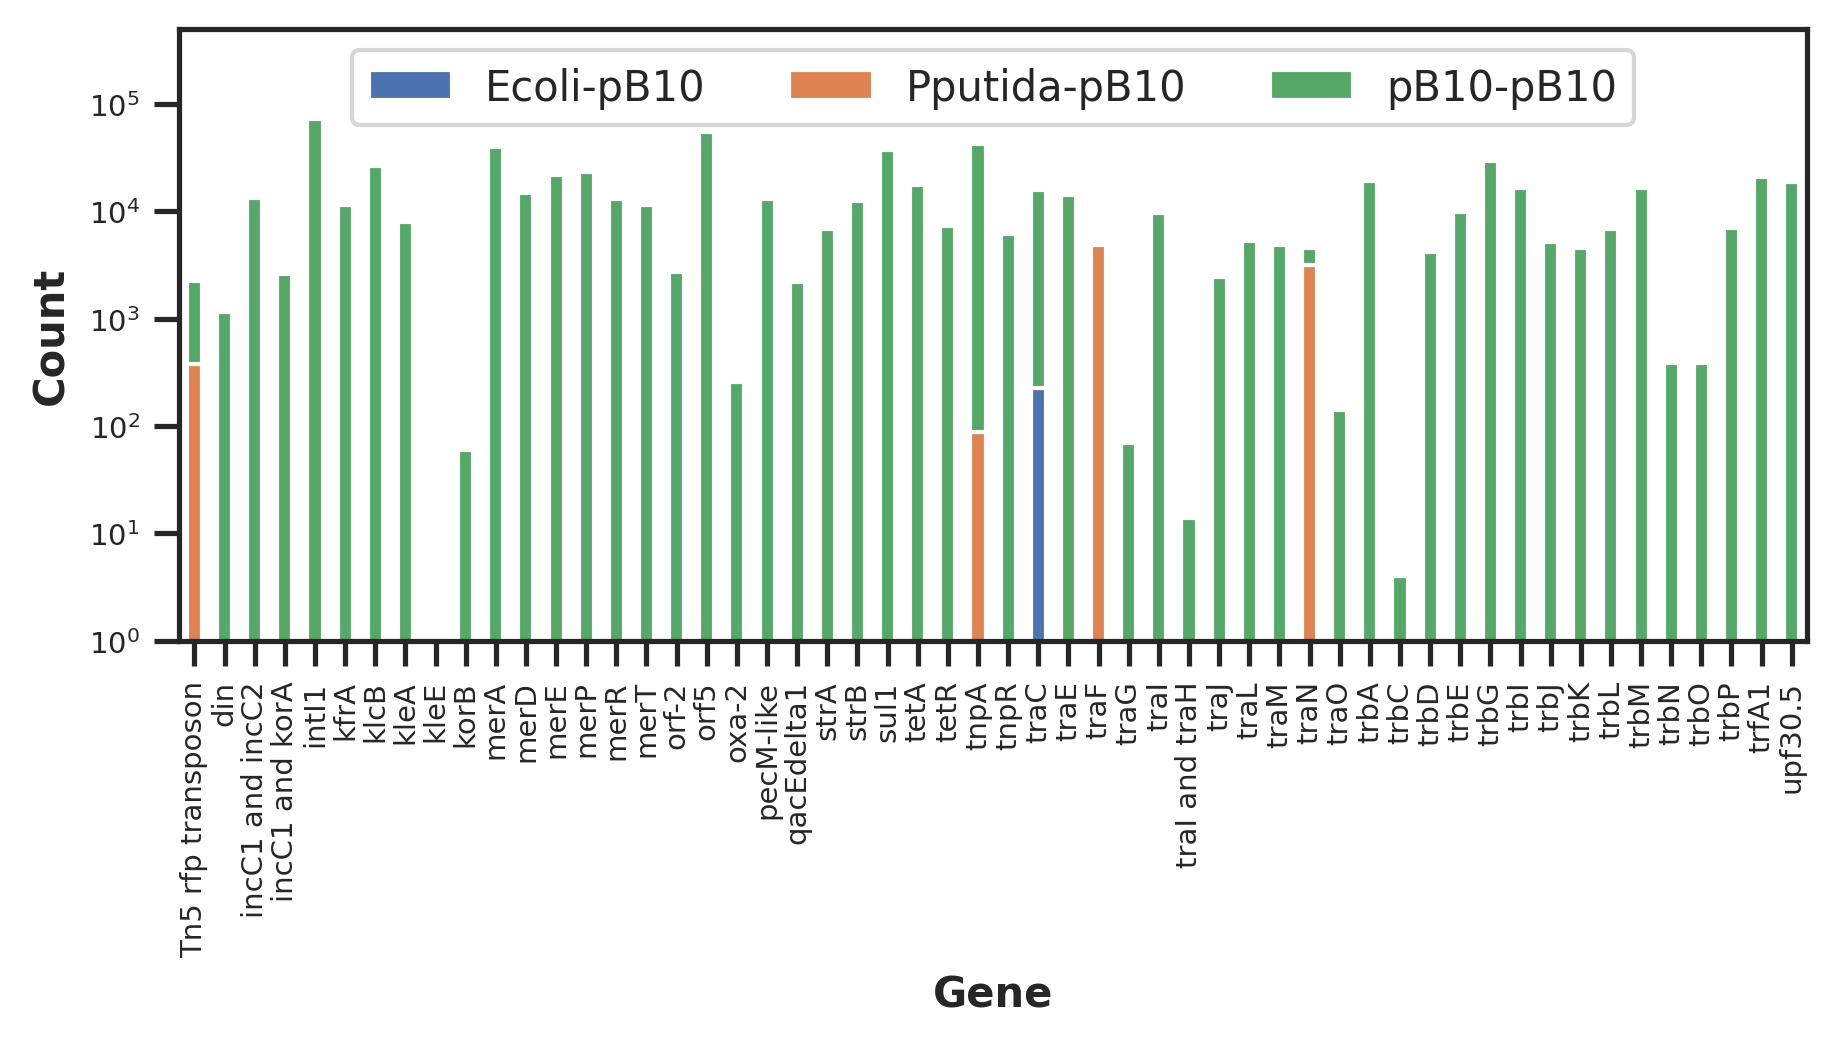

In [27]:
import os
os.chdir('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/figures/')

def extract_gene(loc_list):
    plasmid = SeqIO.read('../../02_ref_genomes/pB10__rfp putative.gb', 'genbank')
    location = []
    gene = []
    for loc in loc_list:
        temp = []
        temp_l = []
        for feature in plasmid.features:
            if feature.type == 'gene' and loc in feature:
                if 'gene' in feature.qualifiers.keys():
                    t = feature.qualifiers['gene']
                    temp.append(str(t)[2:-2])
                    temp_l.append(loc)
                else:
                    t = feature.qualifiers['standard_name']
                    temp.append(str(t)[2:-2])
                    temp_l.append(loc)
        if len(temp_l) == 1:
            location.append(temp_l[0])
            gene.append(str(temp[0]))
        elif len(temp_l) == 2:
            location.append(temp_l[0])
            gene.append(str(temp[0])+' and '+str(temp[1]))
    return([location, gene])

"""def conv_to_counts(linked_reads, loc_and_gene):
    no_gene = len(linked_reads) - (len(loc_and_gene[0]))
    all_genes = loc_and_gene[1]
    unique_genes = list(set(loc_and_gene[1]))
    apps = []
    for i in unique_genes:
        apps.append(all_genes.count(i))
    unique_genes.append('No gene')
    apps.append(no_gene)
    return(unique_genes, apps)"""

def conv_to_counts(loc_and_gene):
    all_genes = loc_and_gene[1]
    unique_genes = list(set(loc_and_gene[1]))
    apps = []
    for i in unique_genes:
        apps.append(all_genes.count(i))
    return(unique_genes, apps)

locations = locations_import('../../06_output/enrichment_comparison/Ctrl+_locations.txt')

ctrl1_pb_pb_genes = extract_gene(locations[1][1])
ctrl1_pb_ecoli_genes = extract_gene(locations[1][2])
ctrl1_pb_pputida_genes = extract_gene(locations[1][0])

ctrl1_pb_pb_counts = conv_to_counts(ctrl1_pb_pb_genes)
ctrl1_pb_ecoli_counts = conv_to_counts(ctrl1_pb_ecoli_genes)
ctrl1_pb_pputida_counts = conv_to_counts(ctrl1_pb_pputida_genes)

ctrl1_pb_pb_df = pd.DataFrame(list(zip(ctrl1_pb_pb_counts[0],ctrl1_pb_pb_counts[1])), columns=[1,2]).explode(2).reset_index(drop=True).add_prefix('column')
ctrl1_pb_ecoli_df = pd.DataFrame(list(zip(ctrl1_pb_ecoli_counts[0],ctrl1_pb_ecoli_counts[1])), columns=[1,2]).explode(2).reset_index(drop=True).add_prefix('column')
ctrl1_pb_pputida_df = pd.DataFrame(list(zip(ctrl1_pb_pputida_counts[0],ctrl1_pb_pputida_counts[1])), columns=[1,2]).explode(2).reset_index(drop=True).add_prefix('column')

ctrl1_pb_pb_df.loc[54] = ['tnpA', 23822+18468]
ctrl1_pb_pb_df.drop([47,32], inplace=True)
ctrl1_pb_pb_df.rename(columns={'column1':'Gene', 'column2':'pB10-pB10'}, inplace=True)
ctrl1_pb_pputida_df.loc[2] = ['tnpA', 88]
ctrl1_pb_pputida_df.rename(columns={'column1':'Gene', 'column2':'Pputida-pB10'}, inplace=True)
ctrl1_pb_ecoli_df.rename(columns={'column1':'Gene', 'column2':'Ecoli-pB10'}, inplace=True)
combined_df = ctrl1_pb_ecoli_df.merge(ctrl1_pb_pputida_df, on='Gene', how='outer').merge(ctrl1_pb_pb_df, on='Gene', how='outer')
combined_df.fillna(0, inplace=True)
combined_df = combined_df.sort_values(by=['Gene']).set_index('Gene')

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Helvetica"
})

#Supplementary figure
fig, ax1 = plt.subplots(figsize=(7,2.7), dpi=300)
combined_df.plot.bar(stacked=True, ax=ax1)
ax1.set(yscale='log')
ax1.set_ylabel('Count', fontsize=10, fontweight='bold')
ax1.set_xlabel('Gene', fontsize=10, fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.legend(loc='upper center', ncol=3)
plt.setp(ax1.get_legend().get_texts(), fontsize=10)
ax1.set_ylim(1, 500000)
ax1.minorticks_off()

plt.savefig('supp3.pdf', bbox_inches='tight', dpi=300)
plt.savefig('supp3.png', bbox_inches='tight', dpi=300)

#### Figure S3

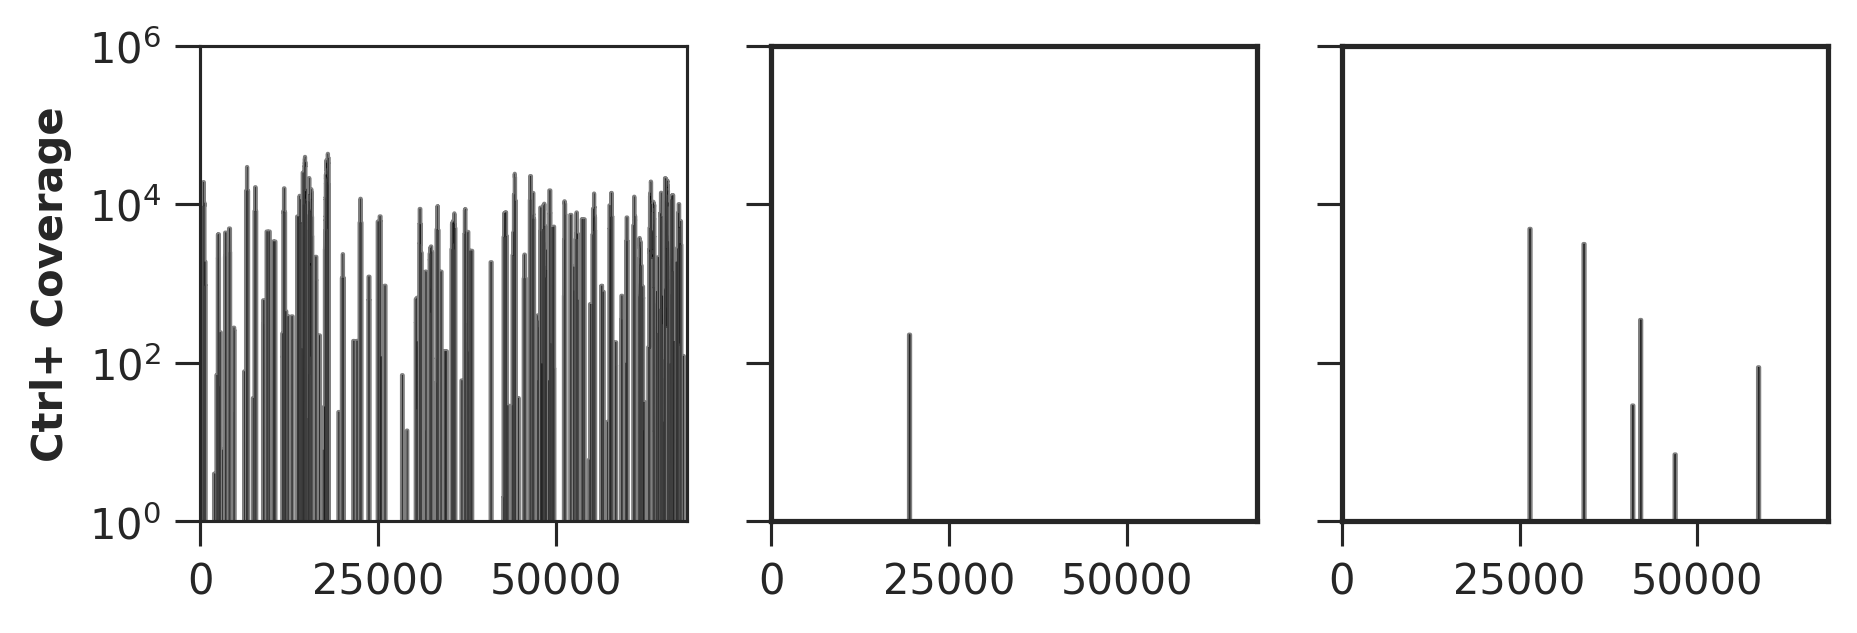

In [8]:
os.chdir('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/enrichment_comparison/')

####FigureS3
figs3b = plt.figure(figsize=(7, 2.1), dpi=300)
gs = figs3b.add_gridspec(100, 100)

rc = {'font.size': 10.0, 'axes.labelsize': 10.0, 'axes.titlesize': 10.0, 'xtick.labelsize': 10.0,
      'ytick.labelsize': 10.0, 'legend.fontsize': 10.0, 'legend.title_fontsize': 10.0, "font.family": "Helvetica"}
sns.set(style='ticks', rc=rc)


ax1 = figs3b.add_subplot(gs[:,0:30])
ax2 = figs3b.add_subplot(gs[:,35:65])
ax3 = figs3b.add_subplot(gs[:,70:])


#make coverage plots
plot_coverage('Ctrl+_plasmid_coverage.csv', ax1, ax2, ax3, 'on')
ax1.set_ylabel('Ctrl+ Coverage', fontsize=10, fontweight='bold')

plt.savefig('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/figures/figs3b.pdf', bbox_inches='tight', dpi=300)

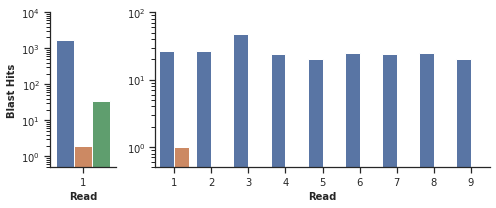

In [9]:
os.chdir('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/enrichment_comparison/')
control = locations_import('Ctrl+_locations.txt')
ecoli_pb10, pputida_pb10 = list(set(control[1][3])), list(set(control[1][4]))

ecoli_genome = import_fasta('../../02_ref_genomes/NC_000913.3_gfp.fasta')[1]
pputida_genome = "".join(import_fasta('../../02_ref_genomes/p.putida_KT2440.fasta')[1:])

name = '>ecoli_1\n'
sequence = ecoli_genome[ecoli_pb10[0]:ecoli_pb10[0]+159]+'\n'

ofile = open("hic_reads.txt", "w")
ofile.write(name+sequence)

count=0
for position in pputida_pb10:
    count+=1
    name='>pputida_'+str(count)+'\n'
    sequence = pputida_genome[position:position+159]+'\n'
    ofile.write(name+sequence)
ofile.close()

blast_results = pd.DataFrame({'Hi-C Read': ['Ecoli-pB10', 'Ecoli-pB10', 'Ecoli-pB10', 
                                            'Pputida-pB10', 'Pputida-pB10', 'Pputida-pB10', 'Pputida-pB10', 'Pputida-pB10', 
                                            'Pputida-pB10', 'Pputida-pB10', 'Pputida-pB10', 'Pputida-pB10', 'Pputida-pB10'], 
                              'Genus': ['Escherichia', 'Salmonella', 'Shigella',
                                        'Pseudomonas', 'Priestia', 'Pseudomonas', 'Pseudomonas', 'Pseudomonas', 
                                        'Pseudomonas', 'Pseudomonas', 'Pseudomonas', 'Pseudomonas', 'Pseudomonas'],
                              'Count': [1694, 2, 34, 
                                        27, 1, 27, 48, 24, 20, 25, 24, 25, 20],
                              'Sequence': [1, 1, 1, 
                                           1, 1, 2, 3, 4, 5, 6, 7, 8, 9]})
figs3c, (ax1, ax2) = plt.subplots(1,2, figsize=(7,3), gridspec_kw={'width_ratios': [1, 5]}, tight_layout=True)
sns.barplot(data=blast_results.loc[blast_results['Hi-C Read']=='Ecoli-pB10'], 
            x='Sequence', y='Count', hue='Genus', ax=ax1)
sns.barplot(data=blast_results.loc[blast_results['Hi-C Read']=='Pputida-pB10'], 
            x='Sequence', y='Count', hue='Genus', ax=ax2)
sns.despine()
ax1.set_xlabel('Read', fontweight='bold', fontsize=10)
ax1.set_ylabel('Blast Hits', fontweight='bold', fontsize=10)
ax1.set_yscale('log')
ax1.set_ylim(.5,10000)
ax1.legend('',frameon=False)

ax2.set_xlabel('Read', fontweight='bold', fontsize=10)
ax2.set_ylabel('', fontweight='bold', fontsize=10)
ax2.set_yscale('log')
ax2.set_ylim(.5,100)
ax2.legend('',frameon=False)
plt.savefig('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/figures/figs3c.pdf', bbox_inches='tight', dpi=300)

## De novo analysis

### Data wrangling

In [47]:
def process_data(reads_file, kraken_file, taxon_file):
    #import the three files
    reads = pd.concat(pd.read_csv(reads_file, chunksize=1000000, sep=','))
    kraken = pd.concat(pd.read_csv(kraken_file, chunksize=1000000, sep='\t', header=None))
    taxon = pd.concat(pd.read_csv(taxon_file, chunksize=1000000, sep='\t'))
    
    #add the seqid and classification column from kraken to taxon file
    taxon['classified'], taxon['seqid']  = kraken[0], kraken[1]
    
    #merge taxon info with potential hosts dataframe
    reads_merged = reads.merge(taxon, how='left',on='seqid')
    reads_merged.drop(columns=['taxid'], inplace=True)
    
    return(reads_merged)


def coverage(newhostsdf):
    
    global p_unaligned
    p_unaligned = [0]*pb10_len
    
    #separate into types of reads
    unalignedpb10 = newhostsdf.loc[newhostsdf['link']=='unalignedpB10']
    pb10unaligned = newhostsdf.loc[newhostsdf['link']=='pB10unaligned']
    
    #remove duplicates
    unalignedpb10 = unalignedpb10.drop_duplicates(subset=['R2loc', 'R2length', 'kingdom','phylum','class','order','family','genus','species']).reset_index(drop=True)
    pb10unaligned = pb10unaligned.drop_duplicates(subset=['R1loc', 'R1length', 'kingdom','phylum','class','order','family','genus','species']).reset_index(drop=True)
    
    #update coverage lists
    unalignedpb10.apply(lambda row: update_counts('unaligned', 'plasmid', int(row['R2loc']), int(row['R2length'])), axis=1)
    pb10unaligned.apply(lambda row: update_counts('plasmid', 'unaligned', int(row['R1loc']), int(row['R1length'])), axis=1)

    #place into df
    data = pd.DataFrame({'position':list(range(0,pb10_len)), 
                         'p_unaligned':p_unaligned})
    return(data)

def update_counts(ref, link, start_index, length):
    """
    Function that updates a list containing the coverage of each base on the pB10 genome. Input is ref (what the first read aligns to), 
    link (what the second read aligns to), start_index (where on the pB10 genome the reads align to), and length (length of the read).
    For each type of read, the list is iteratively updated and returns three lists that can be used for coverage maps. The three output
    lists (p_unaligned, p_ecoli, p_p) contain the coverage lists conferred by pb10_unaligned, pb10_ecoli, and pB10_pB10 hic reads
    respectively.
    """
    global p_unaligned
    
    if ref == 'plasmid':
        if link == 'unaligned':
            s = start_index
            e = start_index + length + 1
            for i in range(s, e):
                if i < pb10_len:
                    p_unaligned[i] += 1
                else:
                    i = i - pb10_len
                    p_unaligned[i] += 1

    if link == 'plasmid':
        if ref == 'unaligned':
            s = start_index
            e = start_index + length + 1
            for i in range(s, e):
                if i < pb10_len:
                    p_unaligned[i] += 1
                else:
                    i = i - pb10_len
                    p_unaligned[i] += 1
                    
def calculate_metrics(unaligned_pB10, control):
    percent_cov = (np.count_nonzero(unaligned_pB10)/pb10_len)*100
    
    unique = []
    for i, j in zip(control, unaligned_pB10):
        if i == 0 and j > 0:
            unique.append(1)
        else:
            unique.append(0)
    percent_unique = (np.count_nonzero(unique)/control.count(0))*100
    
    return(percent_cov, percent_unique)

def metrics_breakdown(newhosts, ctrl):
    data = []
    levels = ['kingdom','phylum','class','order','family','genus','species']

    for level in levels:
        unique_entries = set(newhosts[level].to_list())
        for entry in unique_entries:
            if str(entry) == 'nan':
                pass
            else:
                global p_unaligned
                p_unaligned = [0]*pb10_len
                
                df = newhosts.loc[newhosts[level]==entry]
                
                unalignedpb10 = df.loc[df['link']=='unalignedpB10']
                pb10unaligned = df.loc[df['link']=='pB10unaligned']
                
                unalignedpb10 = unalignedpb10.drop_duplicates(subset=['link', 'R2loc', 'kingdom','phylum','class','order','family','genus','species']).reset_index(drop=True)
                pb10unaligned = pb10unaligned.drop_duplicates(subset=['link', 'R1loc', 'kingdom','phylum','class','order','family','genus','species']).reset_index(drop=True)

                unalignedpb10.apply(lambda row: update_counts('unaligned', 'plasmid', int(row['R2loc']), int(row['R2length'])), axis=1)
                pb10unaligned.apply(lambda row: update_counts('plasmid', 'unaligned', int(row['R1loc']), int(row['R1length'])), axis=1)
                
                coverage, unique = calculate_metrics(p_unaligned, ctrl)
                score = (coverage + unique)/2
                reads = len(unalignedpb10['R1loc'].to_list()) + len(pb10unaligned['R1loc'].to_list())
                
                data.append([level, entry, coverage, unique, score, reads])
    data_df = pd.DataFrame(data, columns=['class', 'entry', 'Coverage','Unique Bases', 'score', 'reads'])
    return(data_df)

def analyze_hosts(libraries, ctrl):
    combined_df = pd.DataFrame(columns=['Library', 'class', 'entry', 'Coverage','Unique Bases', 'score', 'reads'])
    for library in libraries:
        reads = library + '_pb10_unaligned.csv'
        kraken = library + '_out.kraken2'
        lineage = library + '_lineage.txt'
        unaligned_pb10 = process_data(reads, kraken, lineage)
        all_coverage = coverage(unaligned_pb10)
        results = metrics_breakdown(unaligned_pb10, ctrl)
        results['Library'] = library
        
        #unaligned_pb10.to_csv('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/de_novo/'+library+'unaligned_pb10.csv')
        #all_coverage.to_csv('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/de_novo/'+library+'coverage.csv')
        #results.to_csv('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/de_novo/'+library+'_identified_hosts.csv')
        
        combined_df = combined_df.append(results)
    return(combined_df)

In [50]:
pb10_len = 68345
os.chdir('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/denovo/')
ctrl = pd.read_csv('Ctrl+_plasmid_coverage.csv')
ctrl['sum'] = ctrl[['pb10_pb10', 'pb10_ecoli']].sum(axis=1)
ctrl_detected = ctrl['sum'].to_list()
os.chdir('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/denovo/')
results = analyze_hosts(['A', 'B', 'C', 'D', 'E', 'B+', 'C+', 'D+', 'E+', 'F+'], ctrl_detected)

([<matplotlib.axis.YTick at 0x7f0e03d41588>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

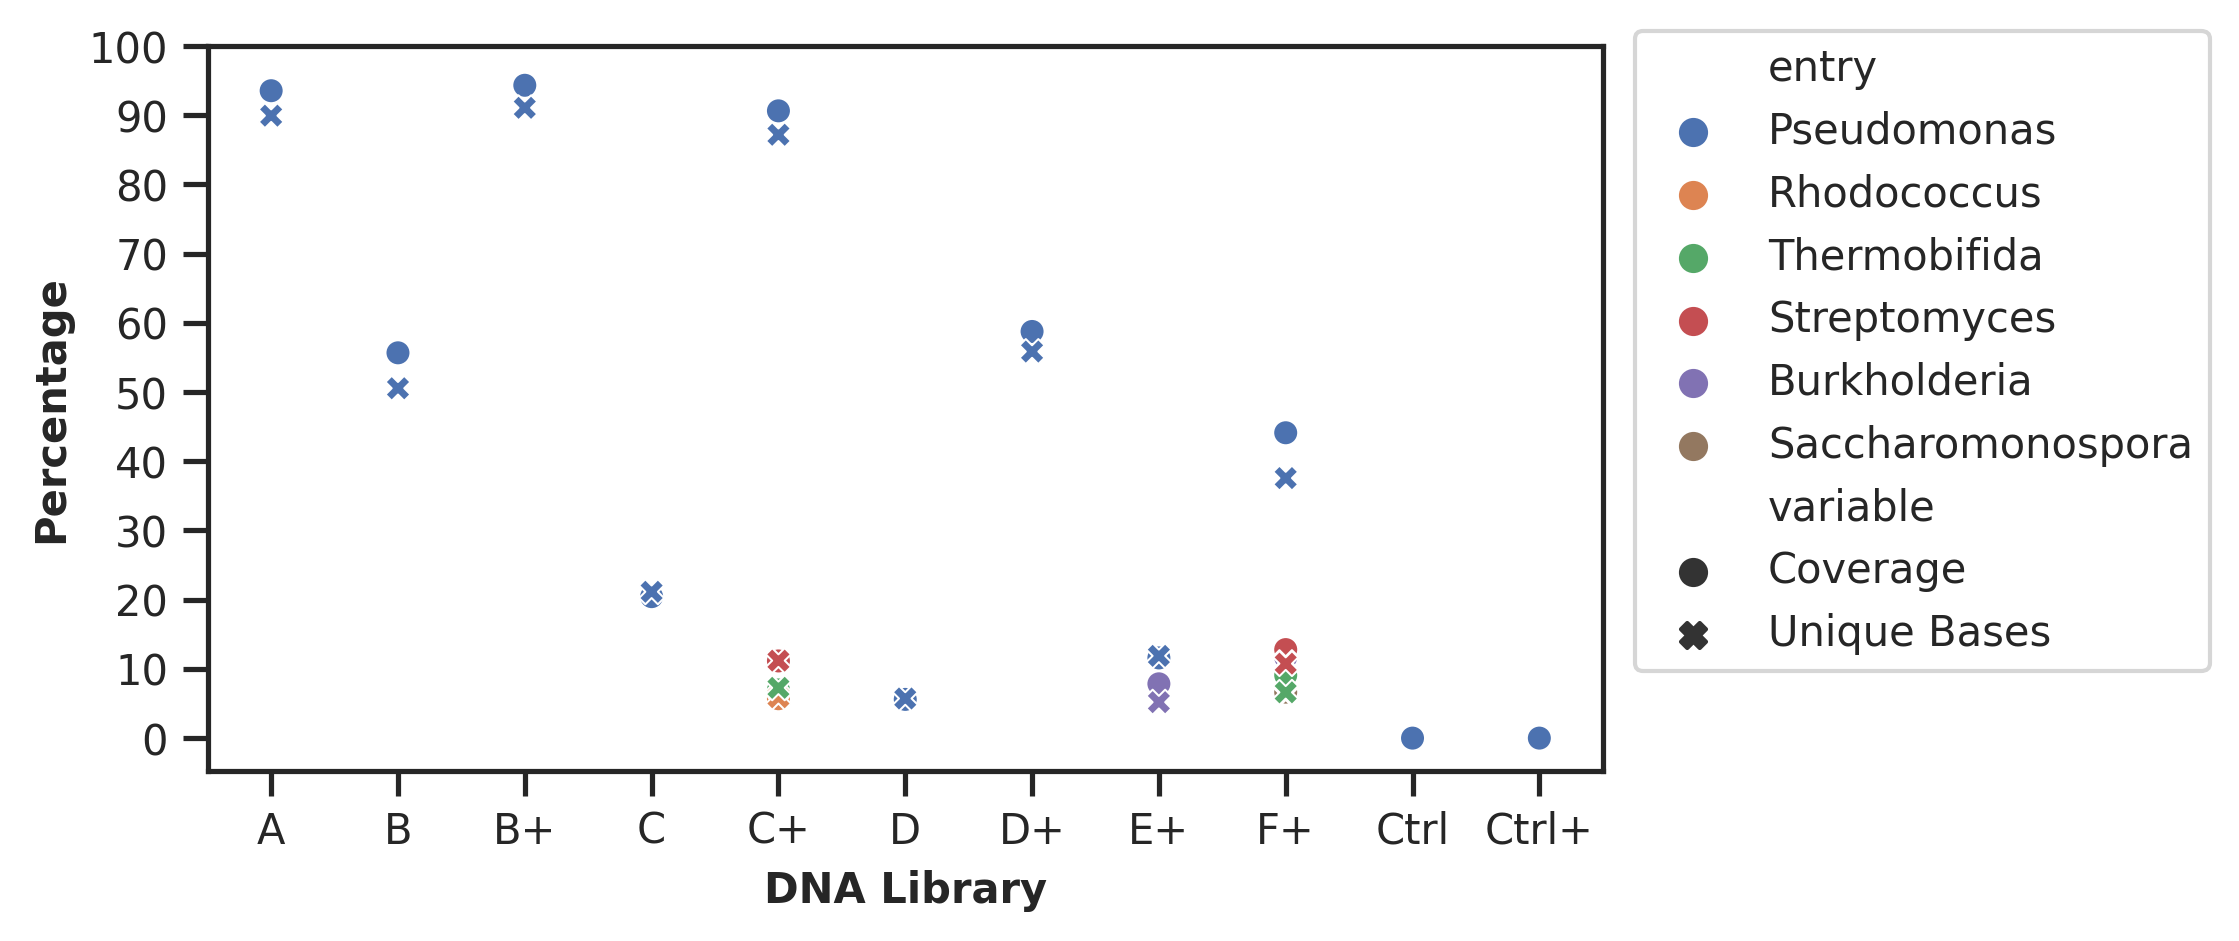

In [51]:
data = results.loc[(results['class']=='genus') & (results['score']>5) & (results['entry']!='Homo')].sort_values(by=['Library', 'score'], ascending=True)
data2 = pd.melt(data, id_vars=['Library', 'entry'], value_vars=['Coverage', 'Unique Bases'])
data2.loc[len(data2.index)] = ['Ctrl', 'Pseudomonas', 'Coverage', 0]
data2.loc[len(data2.index)] = ['Ctrl+', 'Pseudomonas', 'Coverage', 0]

rc = {'font.size': 10.0, 'axes.labelsize': 10.0, 'axes.titlesize': 10.0, 'xtick.labelsize': 10.0,
      'ytick.labelsize': 10.0, 'legend.fontsize': 10.0, 'legend.title_fontsize': 10.0, "font.family": "Helvetica"}
sns.set(style='ticks', rc=rc)

fig7, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6,3.2), dpi=300)
sns.scatterplot(data = data2, y='value', x='Library', hue='entry', style="variable", ax=ax1)
ax1.set_ylabel('Percentage', fontsize=10, fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.set_xlabel('DNA Library', fontsize=10, fontweight='bold')
ax1.legend(loc='upper right', bbox_to_anchor=(1.45,1.05))
plt.yticks(list(range(0,110, 10)))
#plt.savefig('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/figures/fig7.pdf', bbox_inches='tight', dpi=300)